# Example of using the Borehole3D class

## Imports

In [1]:
from striplog import Component, Decor, Legend, Lexicon, Striplog
from core.visual import Borehole3D, striplog_legend_to_omf_legend 
from utils.lexicon.lexicon_memoris import LEG_CONTAMINATION_LEV
from utils.config import DEFAULT_LITHO_LEXICON, DEFAULT_LITHO_LEGEND, DEFAULT_POL_LEXICON
from utils.io import dataframe_viewer
from utils.orm import boreholes_from_dataframe
from utils.visual import legend_from_attributes
from core.project import Project
from core.orm import BoreholeOrm, PositionOrm, Base 

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from definitions import ROOT_DIR

## Reading of CSV files in a dir

In [2]:
save_dir = ROOT_DIR+'/CF_data/Donnees_fusionnees/final_data/'

In [3]:
df = pd.read_csv(save_dir+'Final_dataset.csv', sep=',')

In [4]:
dataframe_viewer(df, rows=5, un_val='ID')

Rows : 112, columns : 131, Unique values on col 'ID': 46


interactive(children=(IntSlider(value=5, description='rows', max=112, min=5, readout=False), IntSlider(value=1…

## Data Checking

In [5]:
df.rename({'Ech_base':'Base_intv', 'Ech_top':'Top_intv', 'Ep_litho':'Epais_intv', 'Description':'Lithology'}
          , axis='columns', inplace=True)

In [6]:
df['Epais_intv'] = df['Base_intv'] - df['Top_intv']

In [7]:
df['Diam_for'] = df['Diam_for']/1000
df.insert(list(df.columns).index('Long_for')+1, 'Diam_for', df.pop('Diam_for'))

In [8]:
dataframe_viewer(df, rows=3, un_val='ID_ech')

Rows : 112, columns : 132, Unique values on col 'ID_ech': 112


interactive(children=(IntSlider(value=3, description='rows', max=112, min=3, readout=False), IntSlider(value=1…

## Create Boreholes from dataframes or files

In [9]:
boreholes, components, link_intv_comp = boreholes_from_dataframe(df, verbose=False,
                                                attributes=['Lithology'], average_z=102,
                                                symbols={'lithology':{'lexicon':DEFAULT_LITHO_LEXICON}}, 
                                                diameter='Diam_for', thickness='Epais_intv')


Dataframe processing...

|__ID:'201'
Summary : dict_values([Striplog(2 Intervals, start=0.0, stop=0.8999999999999999)])

|__ID:'205'
Summary : dict_values([Striplog(4 Intervals, start=0.0, stop=1.5)])

|__ID:'208'
Summary : dict_values([Striplog(4 Intervals, start=0.0, stop=1.4999999999999996)])

|__ID:'207'
Summary : dict_values([Striplog(5 Intervals, start=0.0, stop=1.8000000000000007)])

|__ID:'212'
Summary : dict_values([Striplog(4 Intervals, start=0.0, stop=1.4999999999999991)])

|__ID:'214'
Summary : dict_values([Striplog(4 Intervals, start=0.0, stop=1.6999999999999997)])

|__ID:'217'
Summary : dict_values([Striplog(4 Intervals, start=0.0, stop=1.5000000000000004)])

|__ID:'221'
Error : No value matches with 'Vide ' in given lexicon
Summary : dict_values([Striplog(1 Intervals, start=0.0, stop=0.4)])

|__ID:'223'
Summary : dict_values([Striplog(2 Intervals, start=0.0, stop=0.8)])

|__ID:'?2'
Summary : dict_values([Striplog(1 Intervals, start=0.0, stop=0.3999999999999999)])

|__ID

/home/yanathan/Projects/GSDMA/utils/orm.py:121: SAWarning: relationship 'ComponentOrm.intervals' will copy column Components.id to column Linkintervalcomponent.comp_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Components.id to Linkintervalcomponent.comp_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="components"' to the 'ComponentOrm.intervals' relationship.
  boreholes_orm.append(BoreholeOrm(id=bh_name, date=bh_date))
/home/yanathan/Projects/GSDMA/utils/orm.py:121: SAWarning: relationship 'ComponentOrm.intervals' will copy column Intervals.id to column Linkintervalcomponent.intv_id, which conflic

In [10]:
len(boreholes), len(components)

(46, 8)

## Create a project and save data in a database

In [11]:
DB_name = 'tmp_files/real_orm_db.db'

if os.path.exists(DB_name):
    os.remove(DB_name)

engine = create_engine(f"sqlite:///{DB_name}", echo=True)

In [12]:
Base.metadata.create_all(engine)

2021-10-12 22:19:26,881 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-10-12 22:19:26,882 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Boreholes")
2021-10-12 22:19:26,883 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-10-12 22:19:26,886 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Boreholes")
2021-10-12 22:19:26,886 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-10-12 22:19:26,887 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Samples")
2021-10-12 22:19:26,888 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-10-12 22:19:26,889 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Samples")
2021-10-12 22:19:26,890 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-10-12 22:19:26,891 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Intervals")
2021-10-12 22:19:26,892 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-10-12 22:19:26,892 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Intervals")
2021-10-12 22:19:26,893 INFO sqlalchemy.engine.Engine [raw

In [13]:
Session = sessionmaker(bind=engine)
session = Session()

## Create a legend dictionary for the project

In [14]:
legend_dict = legend_from_attributes([('lithology', DEFAULT_LITHO_LEGEND)])

In [15]:
p = Project(session, legend_dict=legend_dict, lexicon=DEFAULT_LITHO_LEXICON)

2021-10-12 22:19:26,982 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-10-12 22:19:26,984 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-10-12 22:19:26,985 INFO sqlalchemy.engine.Engine [generated in 0.00072s] ()


#### Add components and boreholes into the project

In [16]:
p.add_components(components)

2021-10-12 22:19:26,992 INFO sqlalchemy.engine.Engine INSERT INTO "Components" (id, description) VALUES (?, ?)
2021-10-12 22:19:26,995 INFO sqlalchemy.engine.Engine [generated in 0.00244s] ((0, 'Remblais'), (1, 'Boue'), (2, '_'), (3, 'Schistes'), (4, 'Limon'), (5, 'Limons'), (6, 'Béton'), (7, 'Alluvions'))
2021-10-12 22:19:26,997 INFO sqlalchemy.engine.Engine COMMIT
2021-10-12 22:19:27,001 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-10-12 22:19:27,002 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-10-12 22:19:27,003 INFO sqlalchemy.engine.Engine [cached since 0.01862s ago] ()


In [17]:
dataframe_viewer(df, rows=5)

Rows : 112, columns : 132


interactive(children=(IntSlider(value=5, description='rows', max=112, min=5, readout=False), IntSlider(value=1…

In [18]:
for b in boreholes:
    for k, v in b.intervals.items():
        print({b.id:[v.interval_number, v.top.middle, v.base.middle, b.intervals_values[k]]})

{'201': [0, 101.926886, 101.426886, '{"lithology": "remblais"}']}
{'201': [1, 101.426886, 101.02688599999999, '{"lithology": "remblais"}']}
{'205': [0, 101.804167, 101.404167, '{"lithology": "boue"}']}
{'205': [1, 101.404167, 100.904167, '{"lithology": "boue"}']}
{'205': [2, 100.904167, 100.70416700000001, '{"lithology": "boue"}']}
{'205': [3, 100.70416700000001, 100.304167, '{"lithology": "boue"}']}
{'208': [0, 101.847697, 101.347697, '{"lithology": "remblais"}']}
{'208': [1, 101.347697, 101.047697, '{"lithology": "remblais"}']}
{'208': [2, 101.047697, 100.647697, '{"lithology": "remblais"}']}
{'208': [3, 100.647697, 100.347697, '{"lithology": "remblais"}']}
{'207': [0, 101.889132, 101.489132, '{"lithology": "remblais"}']}
{'207': [1, 101.489132, 101.089132, '{"lithology": "remblais"}']}
{'207': [2, 101.089132, 100.689132, '{"lithology": "remblais"}']}
{'207': [3, 100.689132, 100.489132, '{"lithology": "remblais"}']}
{'207': [4, 100.489132, 100.089132, '{"lithology": "remblais"}']}
{'

In [19]:
for bh in boreholes:
    p.add_borehole(bh)

2021-10-12 22:19:27,061 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, date, length, diameter) VALUES (?, ?, ?, ?)
2021-10-12 22:19:27,063 INFO sqlalchemy.engine.Engine [generated in 0.00180s] ('201', None, 0.8999999999999999, 0.075)
2021-10-12 22:19:27,066 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-10-12 22:19:27,067 INFO sqlalchemy.engine.Engine [generated in 0.00108s] ((0, 101.926886, 101.926886, 101.926886, 152890.245758, 122596.47426), (1, 101.426886, 101.426886, 101.426886, 152890.245758, 122596.47426), (2, 101.426886, 101.426886, 101.426886, 152890.245758, 122596.47426), (3, 101.02688599999999, 101.02688599999999, 101.02688599999999, 152890.245758, 122596.47426))
2021-10-12 22:19:27,070 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-10-12 22:19:27,071 INFO sqlalchemy.engine.Engine [g

2021-10-12 22:19:27,138 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:27,139 INFO sqlalchemy.engine.Engine [cached since 0.05091s ago] (8,)
2021-10-12 22:19:27,140 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:27,141 INFO sqlalchemy.engine.Engine [cached since 0.0487s ago] (9,)
2021-10-12 22:19:27,142 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "P

2021-10-12 22:19:27,206 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-10-12 22:19:27,208 INFO sqlalchemy.engine.Engine [cached since 0.1414s ago] ((20, 101.889132, 101.889132, 101.889132, 152892.92499700002, 122592.662277), (21, 101.489132, 101.489132, 101.489132, 152892.92499700002, 122592.662277), (22, 101.489132, 101.489132, 101.489132, 152892.92499700002, 122592.662277), (23, 101.089132, 101.089132, 101.089132, 152892.92499700002, 122592.662277), (24, 101.089132, 101.089132, 101.089132, 152892.92499700002, 122592.662277), (25, 100.689132, 100.689132, 100.689132, 152892.92499700002, 122592.662277), (26, 100.689132, 100.689132, 100.689132, 152892.92499700002, 122592.662277), (27, 100.489132, 100.489132, 100.489132, 152892.92499700002, 122592.662277), (28, 100.489132, 100.489132, 100.489132, 152892.92499700002, 122592.662277), (29, 100.089132, 100.089132, 100.089132, 152892.92499700002, 122592.662277))
2021-10-12 

2021-10-12 22:19:27,260 INFO sqlalchemy.engine.Engine COMMIT
2021-10-12 22:19:27,264 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-10-12 22:19:27,264 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-10-12 22:19:27,265 INFO sqlalchemy.engine.Engine [cached since 0.2808s ago] ()
2021-10-12 22:19:27,267 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-10-12 22:19:27,268 INFO sqlalchemy.engine.Engine [cached since 0.185s ago] ('212',)
2021-10-12 22:19:27,269 I

2021-10-12 22:19:27,321 INFO sqlalchemy.engine.Engine [cached since 0.2331s ago] (40,)
2021-10-12 22:19:27,323 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:27,323 INFO sqlalchemy.engine.Engine [cached since 0.2312s ago] (41,)
2021-10-12 22:19:27,325 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:27,326 INFO sqlalchemy.engine.Engine [cached since 0.2376s ago] (42,)
2021-10-12 22:19:27,327 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

Borehole geometry created successfully !
2021-10-12 22:19:27,381 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-10-12 22:19:27,382 INFO sqlalchemy.engine.Engine [cached since 0.2724s ago] (101.315009, '217')
2021-10-12 22:19:27,384 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, date, length, diameter) VALUES (?, ?, ?, ?)
2021-10-12 22:19:27,385 INFO sqlalchemy.engine.Engine [cached since 0.3235s ago] ('221', None, 0.4, 0.075)
2021-10-12 22:19:27,386 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-10-12 22:19:27,387 INFO sqlalchemy.engine.Engine [cached since 0.3205s ago] ((54, 101.798666, 101.798666, 101.798666, 152882.412821, 122584.570092), (55, 101.39866599999999, 101.39866599999999, 101.39866599999999, 152882.412821, 122584.570092))
2021-10-12 22:19:27,390 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top

2021-10-12 22:19:27,463 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-10-12 22:19:27,464 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-10-12 22:19:27,465 INFO sqlalchemy.engine.Engine [cached since 0.4807s ago] ()
2021-10-12 22:19:27,467 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-10-12 22:19:27,468 INFO sqlalchemy.engine.Engine [cached since 0.3853s ago] ('?2',)
2021-10-12 22:19:27,470 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positi

2021-10-12 22:19:27,555 INFO sqlalchemy.engine.Engine [cached since 0.4888s ago] ((66, 101.669021, 101.669021, 101.669021, 152881.112067, 122580.961648), (67, 101.269021, 101.269021, 101.269021, 152881.112067, 122580.961648), (68, 101.269021, 101.269021, 101.269021, 152881.112067, 122580.961648), (69, 100.769021, 100.769021, 100.769021, 152881.112067, 122580.961648), (70, 100.769021, 100.769021, 100.769021, 152881.112067, 122580.961648), (71, 100.369021, 100.369021, 100.369021, 152881.112067, 122580.961648), (72, 100.369021, 100.369021, 100.369021, 152881.112067, 122580.961648), (73, 99.969021, 99.969021, 99.969021, 152881.112067, 122580.961648)  ... displaying 10 of 12 total bound parameter sets ...  (76, 99.469021, 99.469021, 99.469021, 152881.112067, 122580.961648), (77, 98.969021, 98.969021, 98.969021, 152881.112067, 122580.961648))
2021-10-12 22:19:27,556 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VA

2021-10-12 22:19:27,614 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-10-12 22:19:27,614 INFO sqlalchemy.engine.Engine [cached since 0.5446s ago] ((39, '226', 0, '{"lithology": "remblais"}', 78, 79, None), (40, '226', 1, '{"lithology": "remblais"}', 80, 81, None), (41, '226', 2, '{"lithology": "remblais"}', 82, 83, None), (42, '226', 3, '{"lithology": "remblais"}', 84, 85, None))
2021-10-12 22:19:27,616 INFO sqlalchemy.engine.Engine COMMIT
2021-10-12 22:19:27,621 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-10-12 22:19:27,622 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-10-12 22:19:27,623 INFO sqlalchemy.engine.Engine [cached since 0.6384s ago] ()
2021-10-12 22:19:27,625 INFO sqlalchemy.engine.Eng

2021-10-12 22:19:27,681 INFO sqlalchemy.engine.Engine [cached since 0.5928s ago] (88,)
2021-10-12 22:19:27,683 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:27,684 INFO sqlalchemy.engine.Engine [cached since 0.5917s ago] (89,)
2021-10-12 22:19:27,686 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:27,687 INFO sqlalchemy.engine.Engine [cached since 0.5986s ago] (90,)
2021-10-12 22:19:27,689 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-10-12 22:19:27,760 INFO sqlalchemy.engine.Engine [cached since 0.6773s ago] ('52',)
2021-10-12 22:19:27,762 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:27,763 INFO sqlalchemy.engine.Engine [cached since 0.6748s ago] (98,)
2021-10-12 22:19:27,765 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:27,766 INFO sqlalchemy.engine.Engine [cached since 0.6738s ago] (99,)
2021-10-12 22:19:27,767 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-10-12 22:19:27,834 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-10-12 22:19:27,835 INFO sqlalchemy.engine.Engine [cached since 0.7524s ago] ('303',)
2021-10-12 22:19:27,837 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:27,838 INFO sqlalchemy.engine.Engine [cached since 0.7499s ago] (108,)
2021-10-12 22:19:27,841 INFO sqlalchemy.engine.Engine SELECT "Posi

2021-10-12 22:19:27,934 INFO sqlalchemy.engine.Engine [cached since 0.8242s ago] (101.7, '305')
2021-10-12 22:19:27,935 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, date, length, diameter) VALUES (?, ?, ?, ?)
2021-10-12 22:19:27,936 INFO sqlalchemy.engine.Engine [cached since 0.8747s ago] ('306', None, 0.29999999999999993, 0.075)
2021-10-12 22:19:27,937 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-10-12 22:19:27,937 INFO sqlalchemy.engine.Engine [cached since 0.8709s ago] ((116, 102.0, 102.0, 102.0, 152818.291, 122633.764), (117, 101.7, 101.7, 101.7, 152818.291, 122633.764))
2021-10-12 22:19:27,938 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-10-12 22:19:27,938 INFO sqlalchemy.engine.Engine [cached since 0.5481s ago] (58, '306', 0, '{"lithology": "remblais"}', 116, 117, None)
2021-10-12 2

2021-10-12 22:19:27,998 INFO sqlalchemy.engine.Engine [cached since 0.91s ago] (124,)
2021-10-12 22:19:28,000 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:28,001 INFO sqlalchemy.engine.Engine [cached since 0.9089s ago] (125,)
Borehole geometry created successfully !
2021-10-12 22:19:28,008 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-10-12 22:19:28,009 INFO sqlalchemy.engine.Engine [cached since 0.8991s ago] (102.558428, 'F1aM')
2021-10-12 22:19:28,010 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, date, length, diameter) VALUES (?, ?, ?, ?)
2021-10-12 22:19:28,011 INFO sqlalchemy.engine.Engine [cached since 0.9497s ago] ('F9bM', None, 0.39999999999999997, 0.07

2021-10-12 22:19:28,086 INFO sqlalchemy.engine.Engine [cached since 1.101s ago] ()
2021-10-12 22:19:28,088 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-10-12 22:19:28,089 INFO sqlalchemy.engine.Engine [cached since 1.007s ago] ('F2M',)
2021-10-12 22:19:28,092 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:28,092 INFO sqlalchemy.engine.Engine [cached since 1.00

2021-10-12 22:19:28,163 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-10-12 22:19:28,164 INFO sqlalchemy.engine.Engine [cached since 1.179s ago] ()
2021-10-12 22:19:28,166 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-10-12 22:19:28,167 INFO sqlalchemy.engine.Engine [cached since 1.084s ago] ('F4M',)
2021-10-12 22:19:28,169 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "

2021-10-12 22:19:28,242 INFO sqlalchemy.engine.Engine [cached since 1.176s ago] ((150, 102.66, 102.66, 102.66, 152858.25, 122576.1), (151, 102.25999999999999, 102.25999999999999, 102.25999999999999, 152858.25, 122576.1), (152, 102.25999999999999, 102.25999999999999, 102.25999999999999, 152858.25, 122576.1), (153, 101.75999999999999, 101.75999999999999, 101.75999999999999, 152858.25, 122576.1), (154, 101.75999999999999, 101.75999999999999, 101.75999999999999, 152858.25, 122576.1), (155, 101.25999999999999, 101.25999999999999, 101.25999999999999, 152858.25, 122576.1))
2021-10-12 22:19:28,244 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-10-12 22:19:28,245 INFO sqlalchemy.engine.Engine [cached since 1.175s ago] ((75, 'F6M', 0, '{"lithology": "remblais"}', 150, 151, None), (76, 'F6M', 1, '{"lithology": "remblais"}', 152, 153, None), (77, 'F6M', 2, '{"lithology": "remblais"}', 15

2021-10-12 22:19:28,313 INFO sqlalchemy.engine.Engine [cached since 1.221s ago] (159,)
2021-10-12 22:19:28,315 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:28,316 INFO sqlalchemy.engine.Engine [cached since 1.228s ago] (160,)
2021-10-12 22:19:28,317 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:28,318 INFO sqlalchemy.engine.Engine [cached since 1.226s ago] (161,)
Borehole geometry created successfully !
2021-10-12 22:19:28,329 INFO sqlalchemy.engine.Eng

2021-10-12 22:19:28,404 INFO sqlalchemy.engine.Engine [cached since 1.316s ago] (168,)
2021-10-12 22:19:28,405 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-10-12 22:19:28,406 INFO sqlalchemy.engine.Engine [cached since 1.314s ago] (169,)
Borehole geometry created successfully !
2021-10-12 22:19:28,413 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-10-12 22:19:28,414 INFO sqlalchemy.engine.Engine [cached since 1.304s ago] (102.65, 'F14M')
2021-10-12 22:19:28,415 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, date, length, diameter) VALUES (?, ?, ?, ?)
2021-10-12 22:19:28,416 INFO sqlalchemy.engine.Engine [cached since 1.355s ago] ('F15bM', None, 1.4999999999999996, 0.1)
2021-

2021-10-12 22:19:28,484 INFO sqlalchemy.engine.Engine [cached since 1.392s ago] (177,)
Borehole geometry created successfully !
2021-10-12 22:19:28,494 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-10-12 22:19:28,495 INFO sqlalchemy.engine.Engine [cached since 1.385s ago] (102.65, 'F16M')
2021-10-12 22:19:28,496 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, date, length, diameter) VALUES (?, ?, ?, ?)
2021-10-12 22:19:28,497 INFO sqlalchemy.engine.Engine [cached since 1.436s ago] ('F18b', None, 0.30000000000000004, 0.1)
2021-10-12 22:19:28,498 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-10-12 22:19:28,498 INFO sqlalchemy.engine.Engine [cached since 1.432s ago] ((178, 102.415, 102.415, 102.415, 152888.232669915, 122599.710607154), (179, 102.11500000000001, 102.11500000000001, 102.11500000000001, 152888.232669915, 122599.710607154))
2021-10-12 22:19:28,500 I

2021-10-12 22:19:28,575 INFO sqlalchemy.engine.Engine COMMIT
2021-10-12 22:19:28,579 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-10-12 22:19:28,580 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-10-12 22:19:28,581 INFO sqlalchemy.engine.Engine [cached since 1.597s ago] ()
2021-10-12 22:19:28,584 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-10-12 22:19:28,585 INFO sqlalchemy.engine.Engine [cached since 1.503s ago] ('F20',)
2021-10-12 22:19:28,587 IN

2021-10-12 22:19:28,657 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-10-12 22:19:28,658 INFO sqlalchemy.engine.Engine [cached since 1.674s ago] ()
2021-10-12 22:19:28,661 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-10-12 22:19:28,661 INFO sqlalchemy.engine.Engine [cached since 1.579s ago] ('F22',)
2021-10-12 22:19:28,663 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "

2021-10-12 22:19:28,734 INFO sqlalchemy.engine.Engine [cached since 1.344s ago] (101, 'F24b', 0, '{"lithology": "remblais"}', 202, 203, None)
2021-10-12 22:19:28,735 INFO sqlalchemy.engine.Engine COMMIT
2021-10-12 22:19:28,739 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-10-12 22:19:28,739 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-10-12 22:19:28,740 INFO sqlalchemy.engine.Engine [cached since 1.756s ago] ()
2021-10-12 22:19:28,742 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHER

2021-10-12 22:19:28,814 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-10-12 22:19:28,815 INFO sqlalchemy.engine.Engine [cached since 1.745s ago] ((105, 'F26', 0, '{"lithology": "remblais"}', 210, 211, None), (106, 'F26', 1, '{"lithology": "remblais"}', 212, 213, None), (107, 'F26', 2, '{"lithology": "limons"}', 214, 215, None), (108, 'F26', 3, '{"lithology": "limons"}', 216, 217, None))
2021-10-12 22:19:28,817 INFO sqlalchemy.engine.Engine COMMIT
2021-10-12 22:19:28,821 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-10-12 22:19:28,822 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-10-12 22:19:28,823 INFO sqlalchemy.engine.Engine [cached since 1.839s ago] ()
2021-10-12 22:19:28,826 INFO sqlalchemy.engi

2021-10-12 22:19:28,892 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-10-12 22:19:28,893 INFO sqlalchemy.engine.Engine [cached since 1.827s ago] ((220, 102.75, 102.75, 102.75, 152879.169, 122592.734), (221, 102.35, 102.35, 102.35, 152879.169, 122592.734), (222, 102.35, 102.35, 102.35, 152879.169, 122592.734), (223, 102.05, 102.05, 102.05, 152879.169, 122592.734))
2021-10-12 22:19:28,894 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-10-12 22:19:28,895 INFO sqlalchemy.engine.Engine [cached since 1.825s ago] ((110, 'F27d', 0, '{"lithology": "remblais"}', 220, 221, None), (111, 'F27d', 1, '{"lithology": "limons"}', 222, 223, None))
2021-10-12 22:19:28,897 INFO sqlalchemy.engine.Engine COMMIT
2021-10-12 22:19:28,901 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-10-12 22:19:28,902 INFO sqlalchemy.engine.

In [20]:
p.add_link_components_intervals(link_intv_comp)

2021-10-12 22:19:28,937 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-10-12 22:19:28,939 INFO sqlalchemy.engine.Engine [cached since 1.828s ago] (102.35, 'F27d')
2021-10-12 22:19:28,944 INFO sqlalchemy.engine.Engine INSERT INTO "Linkintervalcomponent" (intv_id, comp_id, extra_data) VALUES (?, ?, ?)
2021-10-12 22:19:28,945 INFO sqlalchemy.engine.Engine [generated in 0.00131s] ((0, 0, ''), (1, 0, ''), (2, 1, ''), (3, 1, ''), (4, 1, ''), (5, 1, ''), (6, 0, ''), (7, 0, '')  ... displaying 10 of 111 total bound parameter sets ...  (110, 0, ''), (111, 5, ''))
2021-10-12 22:19:28,947 INFO sqlalchemy.engine.Engine COMMIT
2021-10-12 22:19:28,951 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-10-12 22:19:28,951 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-10-12 22:19:28,952 

In [21]:
p.commit()
print('Boreholes in the project : ', len(p.boreholes_orm))

2021-10-12 22:19:28,959 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  46


In [22]:
p.boreholes_orm

2021-10-12 22:19:28,968 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-10-12 22:19:28,970 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-10-12 22:19:28,970 INFO sqlalchemy.engine.Engine [generated in 0.00083s] ('201',)
2021-10-12 22:19:28,972 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-10-12 22:19:28,973 INFO sqlalchemy.engine.Engine [cached since 1.89s ago] ('201',)
2021-10-12 22:19:28,975 INFO sqlalchemy.engine.Engine SELE

2021-10-12 22:19:29,021 INFO sqlalchemy.engine.Engine [cached since 0.05107s ago] ('?2',)
2021-10-12 22:19:29,022 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-10-12 22:19:29,023 INFO sqlalchemy.engine.Engine [cached since 1.94s ago] ('?2',)
2021-10-12 22:19:29,025 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-10-12 22:19:29,026 INFO sqlalchemy.engine.Engine [cached since 0.05648s ago] ('?1',)
2021-10-12 22:19:29,028 INFO sqlalche

2021-10-12 22:19:29,066 INFO sqlalchemy.engine.Engine [cached since 1.984s ago] ('303',)
2021-10-12 22:19:29,068 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-10-12 22:19:29,069 INFO sqlalchemy.engine.Engine [cached since 0.09909s ago] ('304',)
2021-10-12 22:19:29,070 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-10-12 22:19:29,070 INFO sqlalchemy.engine.Engine [cached since 1.988s ago] ('304',)
2021-10-12 22:19:29,072 INFO sqlalc

2021-10-12 22:19:29,110 INFO sqlalchemy.engine.Engine [cached since 0.1408s ago] ('F5M',)
2021-10-12 22:19:29,112 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-10-12 22:19:29,113 INFO sqlalchemy.engine.Engine [cached since 2.03s ago] ('F5M',)
2021-10-12 22:19:29,115 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-10-12 22:19:29,117 INFO sqlalchemy.engine.Engine [cached since 0.147s ago] ('F6M',)
2021-10-12 22:19:29,118 INFO sqlalche

2021-10-12 22:19:29,159 INFO sqlalchemy.engine.Engine [cached since 2.076s ago] ('F20',)
2021-10-12 22:19:29,161 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-10-12 22:19:29,162 INFO sqlalchemy.engine.Engine [cached since 0.1922s ago] ('F21',)
2021-10-12 22:19:29,163 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-10-12 22:19:29,164 INFO sqlalchemy.engine.Engine [cached since 2.082s ago] ('F21',)
2021-10-12 22:19:29,166 INFO sqlalch

[<core.orm.BoreholeOrm>(Name=201, Length=101.426886, Diameter=0.075, Intervals=2),
 <core.orm.BoreholeOrm>(Name=205, Length=101.404167, Diameter=0.075, Intervals=4),
 <core.orm.BoreholeOrm>(Name=208, Length=101.347697, Diameter=0.075, Intervals=4),
 <core.orm.BoreholeOrm>(Name=207, Length=101.489132, Diameter=0.075, Intervals=5),
 <core.orm.BoreholeOrm>(Name=212, Length=101.429759, Diameter=0.075, Intervals=4),
 <core.orm.BoreholeOrm>(Name=214, Length=101.45428799999999, Diameter=0.075, Intervals=4),
 <core.orm.BoreholeOrm>(Name=217, Length=101.315009, Diameter=0.075, Intervals=4),
 <core.orm.BoreholeOrm>(Name=221, Length=101.39866599999999, Diameter=0.075, Intervals=1),
 <core.orm.BoreholeOrm>(Name=223, Length=101.278308, Diameter=0.075, Intervals=2),
 <core.orm.BoreholeOrm>(Name=?2, Length=101.289276, Diameter=0.075, Intervals=1),
 <core.orm.BoreholeOrm>(Name=?1, Length=101.289276, Diameter=0.075, Intervals=1),
 <core.orm.BoreholeOrm>(Name=224, Length=101.169021, Diameter=0.075, Inte

In [23]:
p.refresh()

2021-10-12 22:19:29,210 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".date AS "Boreholes_date", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-10-12 22:19:29,212 INFO sqlalchemy.engine.Engine [cached since 2.227s ago] ()


In [24]:
session.close()

2021-10-12 22:19:29,217 INFO sqlalchemy.engine.Engine ROLLBACK


### update project legend dict

In [25]:
p.update_legend_cmap(update_project_legend=True, update_all_attrib=True, verbose=False)

({'lithology': {'legend': Legend(Decor({'_colour': '#d3b798', 'width': 3, 'hatch': "'v'", 'component': Component({'lithology': 'remblai'})})
   Decor({'_colour': '#331100', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'boue'})})
   Decor({'_colour': '#ffffff', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'Inconnu'})})
   Decor({'_colour': '#bbffdd', 'width': 3, 'hatch': "'--'", 'component': Component({'lithology': 'schiste'})})
   Decor({'_colour': '#798732', 'width': 3, 'hatch': "'-.'", 'component': Component({'lithology': 'limon'})})
   Decor({'_colour': '#a5c7c9', 'width': 3, 'hatch': "'t'", 'component': Component({'lithology': 'béton'})})
   Decor({'_colour': '#fff497', 'width': 3, 'hatch': "'....'", 'component': Component({'lithology': 'alluvion'})})),
   'cmap': <matplotlib.colors.ListedColormap at 0x7f0381149d60>,
   'values': ['remblai',
    'boue',
    'Inconnu',
    'schiste',
    'limon',
    'béton',
    'alluvion']}},
 {'201': {'lithol

In [26]:
p.legend_dict['lithology']['legend'] # looks like cmap and values combination

Legend(Decor({'_colour': '#d3b798', 'width': 3, 'hatch': "'v'", 'component': Component({'lithology': 'remblai'})})
Decor({'_colour': '#331100', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'boue'})})
Decor({'_colour': '#ffffff', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'Inconnu'})})
Decor({'_colour': '#bbffdd', 'width': 3, 'hatch': "'--'", 'component': Component({'lithology': 'schiste'})})
Decor({'_colour': '#798732', 'width': 3, 'hatch': "'-.'", 'component': Component({'lithology': 'limon'})})
Decor({'_colour': '#a5c7c9', 'width': 3, 'hatch': "'t'", 'component': Component({'lithology': 'béton'})})
Decor({'_colour': '#fff497', 'width': 3, 'hatch': "'....'", 'component': Component({'lithology': 'alluvion'})}))

# Visualization

## Display one object

In [27]:
bh = p.boreholes_3d
#print(bh.name, '\n', bh.intervals) # problem with top and base position --> kind of overlaying

In [28]:
n = 2
df.query(f'ID=="{p.boreholes_3d[n].name}"')[['ID', 'Top_intv', 'Base_intv', 'Lithology']]

,ID,Top_intv,Base_intv,Lithology
6,208,0.2,0.7,Remblais de couleur brun avec déchets de const...
7,208,2.1,2.4,Remblais de couleur brun avec déchets de const...
8,208,3.0,3.4,Remblais de couleur brun avec déchets de const...
9,208,4.4,4.7,Remblais de couleur brun avec déchets de const...


In [29]:
p.boreholes_3d[n].intervals[0].components #[0].lithology

[Component({'lithology': 'remblai'})]

/home/yanathan/Projects/GSDMA/utils/visual.py:424: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'v". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:311: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'v". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect1 = patches.Rectangle((0, 0),


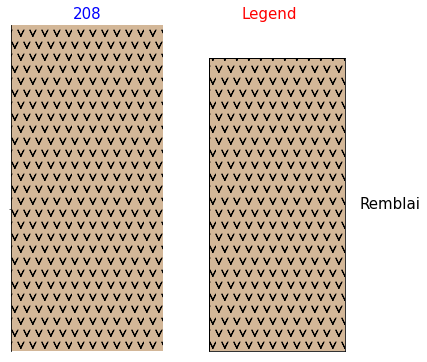

In [30]:
p.boreholes_3d[n].log_plot() #verbose=True)

## mapping of project boreholes

In [31]:
p.plot2d()

In [32]:
p.legend_dict['lithology']['legend']

Legend(Decor({'_colour': '#d3b798', 'width': 3, 'hatch': "'v'", 'component': Component({'lithology': 'remblai'})})
Decor({'_colour': '#331100', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'boue'})})
Decor({'_colour': '#ffffff', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'Inconnu'})})
Decor({'_colour': '#bbffdd', 'width': 3, 'hatch': "'--'", 'component': Component({'lithology': 'schiste'})})
Decor({'_colour': '#798732', 'width': 3, 'hatch': "'-.'", 'component': Component({'lithology': 'limon'})})
Decor({'_colour': '#a5c7c9', 'width': 3, 'hatch': "'t'", 'component': Component({'lithology': 'béton'})})
Decor({'_colour': '#fff497', 'width': 3, 'hatch': "'....'", 'component': Component({'lithology': 'alluvion'})}))

In [33]:
p.plot3d(repr_attribute='lithology', labels_size=15, bg_color=["royalblue", "aliceblue"], 
         window_size=(800, 600), verbose=True)

Borehole "201": 1 --> ['remblai']
Borehole "205": 1 --> ['boue']
Borehole "208": 1 --> ['remblai']
Borehole "207": 1 --> ['remblai']
Borehole "212": 1 --> ['remblai']
Borehole "214": 1 --> ['remblai']
Borehole "217": 1 --> ['remblai']
Borehole "221": 1 --> ['Inconnu']
Borehole "223": 1 --> ['remblai']
Borehole "?2": 1 --> ['remblai']
Borehole "?1": 1 --> ['remblai']
Borehole "224": 1 --> ['remblai']
Borehole "225": 2 --> ['schiste', 'remblai']
Borehole "226": 1 --> ['remblai']
Borehole "50": 1 --> ['remblai']
Borehole "51": 1 --> ['remblai']
Borehole "52": 1 --> ['remblai']
Borehole "302": 1 --> ['remblai']
Borehole "303": 1 --> ['remblai']
Borehole "304": 1 --> ['remblai']
Borehole "305": 1 --> ['remblai']
Borehole "306": 1 --> ['remblai']
Borehole "F1aM": 2 --> ['limon', 'remblai']
Borehole "F9bM": 1 --> ['remblai']
Borehole "F10M": 1 --> ['remblai']
Borehole "F2M": 2 --> ['remblai', 'limon']
Borehole "F3M": 1 --> ['béton']
Borehole "F4M": 1 --> ['limon']
Borehole "F5M": 1 --> ['remb

2021-10-12 22:19:29.904 (   4.002s) [        E11EF740]vtkDataSetAttributes.cx:1296  WARN| vtkPointData (0x3e34520): Can not set attribute Scalars. Only vtkDataArray subclasses can be set as active attributes.
